In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [23]:
df = pd.read_csv('C:/Users/dilshan/Documents/AI_ML_Course(zuu)/week03/zuu_crew_scores.csv')

In [24]:
# Drop non-numeric columns (text not usable for regression)
X = df.drop(columns=["MemberName", "CourseName", "CapstoneScore"])
y = df["CapstoneScore"].values.reshape(-1, 1)   

In [33]:
# Feature scaling (standardization)
"""Custom Standard Scaler for feature standardization.
    
    Standardizes features by removing the mean and scaling to unit variance.
    """


def standard_scale(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X_scaled = standard_scale(X)
if isinstance(X_scaled, pd.DataFrame):
    X_scaled = X_scaled.values
print(X_scaled.shape)  # (150, 7) after encoding

(150, 7)


In [26]:
from itertools import combinations_with_replacement

def polynomial_features(X, degree):
    n_samples, n_features = X.shape
    combos = list(combinations_with_replacement(range(n_features), degree))
    new_features = len(combos)  # Number of terms
    X_poly = np.empty((n_samples, new_features))
    for i, combo in enumerate(combos):
        X_poly[:, i] = np.prod(X[:, combo], axis=1)
    return X_poly

# For full poly (degrees 0 to d), stack for each degree
def full_polynomial_features(X, degree):
    X_poly = np.ones((X.shape[0], 1))  # Bias term (degree 0)
    for d in range(1, degree + 1):
        X_poly = np.hstack((X_poly, polynomial_features(X, d)))
    return X_poly

In [27]:
def linear_regression_fit(X, y):
    # Add bias if not included
    if np.all(X[:, 0] != 1):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
    coef, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    return coef

def linear_regression_predict(X, coef):
    if np.all(X[:, 0] != 1):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ coef

In [28]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [34]:
def k_fold_cv(X, y, degree, k=5, lr: float = 0.01, epochs: int = 1000):
    n = len(y)
    fold_size = n // k
    indices = np.arange(n)
    np.random.shuffle(indices)  # Random shuffle for folds
    
    r2_scores, mse_scores, mae_scores = [], [], []
    
    for i in range(k):
        val_idx = indices[i * fold_size: (i + 1) * fold_size]
        train_idx = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Generate poly features
        X_train_poly = full_polynomial_features(X_train, degree)
        X_val_poly = full_polynomial_features(X_val, degree)
        
        # Fit
        coef = linear_regression_fit(X_train_poly, y_train)
        
        # Predict
        y_pred = linear_regression_predict(X_val_poly, coef)
        
        # Metrics
        r2_scores.append(r2_score(y_val, y_pred))
        mse_scores.append(mse(y_val, y_pred))
        mae_scores.append(mae(y_val, y_pred))
    
    return {
        'mean_r2': np.mean(r2_scores),
        'mean_mse': np.mean(mse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_r2': np.std(r2_scores)
    }

In [31]:
degrees = [1, 2, 3]
results = {}

for deg in degrees:
    print(f"Evaluating degree {deg}...")
    metrics = k_fold_cv(X_scaled, y, deg)
    results[deg] = metrics

# Display results in a table
results_df = pd.DataFrame(results).T
print(results_df)

Evaluating degree 1...
Evaluating degree 2...
Evaluating degree 3...
     mean_r2     mean_mse   mean_mae     std_r2
1   0.331170   394.564065  16.335672   0.135926
2   0.224563   461.007489  16.932742   0.160603
3 -15.138453  9270.001004  69.245927  10.592104


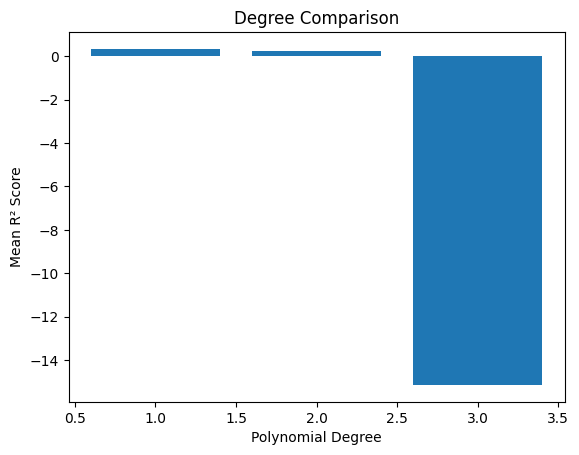

In [32]:
import matplotlib.pyplot as plt

# Example: Bar plot for R²
plt.bar(results_df.index, results_df['mean_r2'])
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean R² Score')
plt.title('Degree Comparison')
plt.show()